Struttura del notebook

3. Suddivisione e Scaling
    - Separazione dei dati in set di addestramento e test.
    - Standardizzazione dei dati numerici.
    - Controllo della suddivisione e scaling.

4. Addestramento e Valutazione del Modello
    - Selezione e addestramento del modello (e.g., Random Forest, Regressione Logistica).
    - Valutazione delle performance del modello (accuratezza, precisione, recall).
    - Tuning degli iperparametri.

5. Conclusioni e Passi Successivi
    - Riepilogo dei risultati e performance.
    - Conclusioni.


## Import Libraries

In [1]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
import pickle

# Split Data & Scaling

In [2]:
df = pd.read_csv('./dataset/preprocessed_data.csv')

#df = pd.read_csv('preprocessed_data.csv')
X = df.drop(columns=['risk_level'])
y = df['risk_level']

In [3]:
# Eseguiamo il primo train-test split con stratificazione per ottenere il 10% dei dati
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, stratify=y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

Si scala le caratteristiche in modo che siano normalizzate con media zero. Questo passaggio è consigliato per le SVM e modelli lineari, poiché facilita l'adattamento del modello. Considerata la presenza di outlier, si è optato per utilizzare uno StandardScaler anziché un MinMaxScaler

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

## Bilanciamento con SMOTE

In [6]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## Correlation

In [7]:
correlation_matrix = df.corr()
correlation_matrix

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,annual_inc,verification_status,dti,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,risk_level
loan_amnt,1.000000,0.999422,0.975037,0.425341,0.126413,0.962657,-0.138926,0.312712,0.271789,0.048789,...,-0.000081,-0.064471,-0.078644,-0.076403,-0.153328,-0.017649,0.005344,-0.091379,-0.027198,0.000288
funded_amnt,0.999422,1.000000,0.975795,0.424549,0.126689,0.963531,-0.138836,0.312503,0.271727,0.049545,...,-0.000254,-0.064722,-0.078693,-0.076479,-0.153569,-0.017733,0.004412,-0.091394,-0.027553,-0.000395
funded_amnt_inv,0.975037,0.975795,1.000000,0.411118,0.145771,0.935050,-0.157779,0.332125,0.280685,0.045124,...,0.000434,-0.052882,-0.066795,-0.063702,-0.129653,-0.014910,0.005130,-0.073297,-0.027416,-0.002578
term,0.425341,0.424549,0.411118,1.000000,0.428491,0.196233,-0.454687,0.058702,0.195264,0.106787,...,-0.000579,-0.016611,-0.024689,-0.027660,-0.046022,-0.006775,-0.005966,-0.034216,-0.014658,0.037528
int_rate,0.126413,0.126689,0.145771,0.428491,1.000000,0.123965,-0.978592,-0.072726,0.218974,0.163686,...,0.041154,-0.018546,0.029714,0.044576,0.092113,0.012574,0.074014,0.018685,0.010434,0.171573
installment,0.962657,0.963531,0.935050,0.196233,0.123965,1.000000,-0.126631,0.305985,0.258453,0.039898,...,0.004953,-0.067911,-0.076185,-0.071845,-0.144868,-0.016172,0.016018,-0.089780,-0.024011,0.010342
sub_grade,-0.138926,-0.138836,-0.157779,-0.454687,-0.978592,-0.126631,1.000000,0.065880,-0.224826,-0.176944,...,-0.041073,0.017252,-0.031001,-0.046128,-0.094438,-0.013124,-0.076761,-0.019230,-0.005820,-0.145156
annual_inc,0.312712,0.312503,0.332125,0.058702,-0.072726,0.305985,0.065880,1.000000,0.084171,-0.177901,...,0.005585,0.003889,-0.004195,-0.008150,-0.018478,-0.000617,0.024406,-0.009128,-0.004319,-0.036766
verification_status,0.271789,0.271727,0.280685,0.195264,0.218974,0.258453,-0.224826,0.084171,1.000000,0.072566,...,0.007533,-0.024601,-0.013693,-0.010680,-0.010756,0.000820,0.028700,-0.010385,-0.011936,0.023902
dti,0.048789,0.049545,0.045124,0.106787,0.163686,0.039898,-0.176944,-0.177901,0.072566,1.000000,...,-0.029192,-0.059916,-0.010793,-0.018553,-0.034583,-0.007374,-0.053317,-0.008682,-0.025457,0.017620


Alta correlazione tra molte delle caratteristiche è un'indicazione che l'uso di tecniche di riduzione della dimensionalità potrebbe essere vantaggioso.

# Feature Reduction

In [8]:
pca = PCA(n_components=len(X_train.columns))
pca.fit(X_train)

PCA(n_components=52)

In [9]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

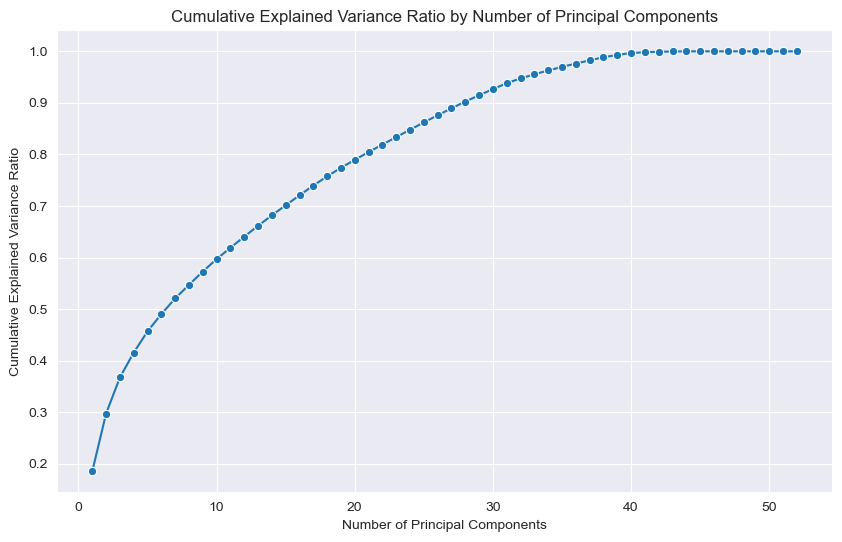

In [10]:
# Create a DataFrame for cumulative explained variance ratio
cvr = pd.DataFrame({
    'Number of Principal Components': range(1, len(cumulative_variance) + 1),
    'Cumulative Explained Variance Ratio': cumulative_variance
})

# Set up the figure
plt.figure(figsize=(10, 6))

# Create the line plot using Seaborn
sns.lineplot(data=cvr, 
             x='Number of Principal Components', 
             y='Cumulative Explained Variance Ratio', 
             marker='o')  # Adding markers for clarity

# Add title and labels
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')

# Add grid lines for better readability
plt.grid(True)

# Show the figure
plt.show()

In [11]:
components_to_retain = np.argmax(cumulative_variance >= 0.9) + 1
pca = PCA(n_components=components_to_retain)

X_train = pca.fit_transform(X_train)

X_test_copy = X_test

X_test = pca.transform(X_test)
components_to_retain

28

## Modeling

### Funzioni di utilità

In [12]:
def save_model(model, filename):
    filename = './models'+'/'+filename
    try:
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        print(f"Modello salvato con successo in: {filename}")
    except Exception as e:
        print(f"Errore nel salvataggio del modello: {e}")

In [13]:
def save_grid_search_results(results, columns_to_save, filename):
    filename = './results'+'/'+filename

    # Seleziona le colonne principali per il CSV
    results_to_save = results[columns_to_save].copy()

    # Identifica il miglior modello basato su mean_test_score
    best_index = results['mean_test_score'].idxmax()  # Indice del miglior punteggio medio

    # Aggiungi una colonna che indica se il modello è il migliore
    results_to_save['is_best_model'] = False
    results_to_save.loc[best_index, 'is_best_model'] = True


    # Salva i risultati in un file CSV
    results_to_save.to_csv(filename, index=False)
    print(f"Risultati salvati con successo in: {filename}")

In [14]:
def plot_confusion_matrix(y_true, y_pred):
    # Calcola la matrice di confusione
    cm = confusion_matrix(y_true, y_pred)

    # Configura la visualizzazione
    plt.figure(figsize=(8,6))
    class_labels = sorted(set(y_true) | set(y_pred))  # Unisce le classi uniche di y_true e y_pred
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

    # Aggiungi titolo e etichette
    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)

    # Mostra il grafico
    plt.show()

In [15]:
def plot_roc_curve(y_true, y_pred_proba):
    # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(11):
            fpr[i], tpr[i], _ = roc_curve(y_true, y_pred_proba[:, i], pos_label=i)
            roc_auc[i] = roc_auc_score(y_true == i, y_pred_proba[:, i]) # AUC for each class

        # Plot all ROC curves
        plt.figure(figsize=(8, 6))
        for i in range(11):
            plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

        plt.plot([0, 1], [0, 1], 'k--')  # Random diagonal
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
        plt.legend(loc="lower right")
        plt.show()

In [16]:
def plot_feature_importance(model, X_train):
    # Crea un DataFrame con le importanze delle feature
    feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': model.feature_importances_})
    feature_imp_df = feature_imp_df.sort_values('Gini Importance', ascending=False)

    # Visualizzazione della tabella delle importanze delle feature
    print(feature_imp_df)

    # Crea un grafico a barre orizzontali per l'importanza delle feature
    plt.figure(figsize=(8,6))
    plt.barh(feature_imp_df['Feature'], feature_imp_df['Gini Importance'], color='skyblue')
    plt.xlabel('Gini Importance')
    plt.title('Feature Importance - Gini Importance')
    plt.gca().invert_yaxis()  # Inverte l'asse y per visualizzare la feature più importante in alto
    plt.show()


### SVM

In [17]:
#Creo il classificatore SVM
svm = SVC()

# Definisco la griglia di iperparametri
param_grid = {
    'C': [1],                    # Ridotto ai valori più comuni per C
    'kernel': ['linear', 'rbf'], # Mantenuto solo il kernel lineare per semplificare
}

# Utilizzo il Grid Search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

#  Miglior modello trovato
print("Migliori parametri trovati: ", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Migliori parametri trovati:  {'C': 1, 'kernel': 'rbf'}


In [18]:
# Predico sul set di test
y_pred = best_svm_model.predict(X_test)

#  Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

Classification report on test set:
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     16182
         1.0       0.05      0.57      0.09       404
         2.0       0.90      0.91      0.91       929

    accuracy                           0.72     17515
   macro avg       0.64      0.73      0.61     17515
weighted avg       0.95      0.72      0.81     17515



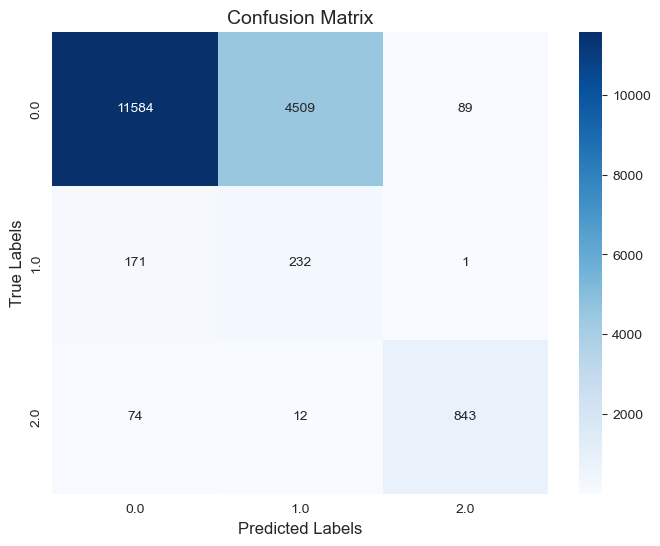

In [19]:
#  Matrice di confusione
plot_confusion_matrix(y_test, y_pred)

In [20]:
#Salvataggio dei risultati
columns_to_save = [
    'param_C', 'param_kernel', # Parametri del modello
    'mean_test_score', 'std_test_score', 'rank_test_score', 'precision', 'recall', 'f1_score', 'accuracy'
]

results = pd.DataFrame(grid_search.cv_results_)
results['precision'] = precision_score(y_test, y_pred, average='weighted')
results['recall'] = recall_score(y_test, y_pred, average='weighted')
results['f1_score'] = f1_score(y_test, y_pred, average='weighted')
results['accuracy'] = accuracy_score(y_test, y_pred)

save_grid_search_results(results, columns_to_save, 'svm_results.csv')

# Salvataggio del miglior modello SVM
save_model(best_svm_model, "best_svm_model.pkl")

Risultati salvati con successo in: ./results/svm_results.csv
Modello salvato con successo in: ./models/best_svm_model.pkl


### Logistic Regression

In [21]:
# Creo il modello Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=200)

# Definisco la griglia di iperparametri
param_grid = {
    'penalty': ['l2'],        # Limitato ai tipi di penalizzazione più comuni
    'C': [0.1, 1, 10],                # Ridotto l'intervallo di valori per C
    'solver': ['lbfgs', 'liblinear'], # Meno solver per velocizzare la ricerca
}

# Grid Search
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1_weighted',  # Ottimizzare per F1-score ponderato
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Miglior modello trovato
print("Migliori parametri trovati: ", grid_search.best_params_)
best_lr_model = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Migliori parametri trovati:  {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\carmo\anaconda3\envs\RiskPrediction\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
# Predizioni sul set di test
y_pred = best_lr_model.predict(X_test)

# Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

Classification report on test set:
              precision    recall  f1-score   support

         0.0       0.98      0.66      0.79     16182
         1.0       0.05      0.65      0.09       404
         2.0       0.90      0.94      0.92       929

    accuracy                           0.68     17515
   macro avg       0.64      0.75      0.60     17515
weighted avg       0.96      0.68      0.78     17515



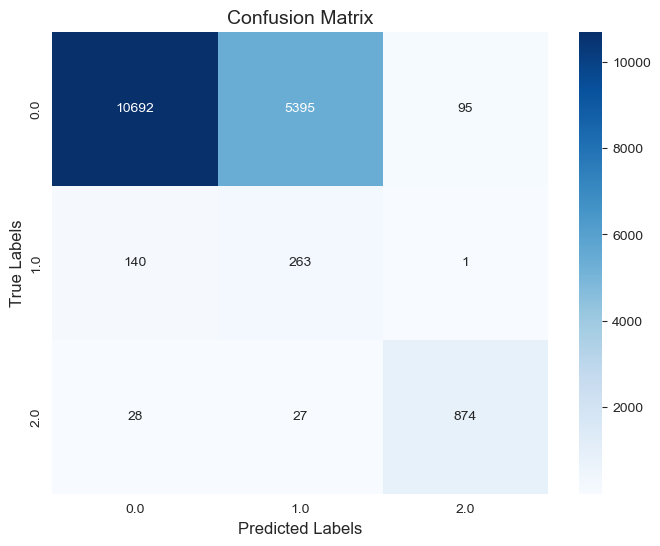

In [23]:
#  Matrice di confusione
plot_confusion_matrix(y_test, y_pred)

In [24]:
#Salvataggio dei risultati
columns_to_save = [
    'param_penalty', 'param_C', 'param_solver',                   # Parametri del modello
    'mean_test_score', 'std_test_score', 'rank_test_score', 'precision', 'recall', 'f1_score', 'accuracy'
]

results = pd.DataFrame(grid_search.cv_results_)
results['precision'] = precision_score(y_test, y_pred, average='weighted')
results['recall'] = recall_score(y_test, y_pred, average='weighted')
results['f1_score'] = f1_score(y_test, y_pred, average='weighted')
results['accuracy'] = accuracy_score(y_test, y_pred)

save_grid_search_results(results, columns_to_save, 'lr_results.csv')

# Salvataggio del miglior modello Logistic Regression
save_model(best_lr_model, "best_lr_model.pkl")

Risultati salvati con successo in: ./results/lr_results.csv
Modello salvato con successo in: ./models/best_lr_model.pkl


### Random Forest


In [25]:
# Creazione il modello Random Forest
rf = RandomForestClassifier(random_state=42)

# Definisco la griglia di iperparametri
param_grid = {
    'n_estimators': [100, 200],          # Numero di alberi (limitato a 100 e 200)
    'max_depth': [7, 10],                # Profondità massima (limitato a 10 e 20)
    'min_samples_leaf': [1, 2],          # Minimo numero di campioni per una foglia (limitato a 1 e 2)
}

# Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_weighted',  # Ottimizzare per F1-score ponderato
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 10], 'min_samples_leaf': [1, 2],
                         'n_estimators': [100, 200]},
             scoring='f1_weighted', verbose=2)

In [26]:
# Individuo il  Miglior modello trovato
print("Migliori parametri trovati: ", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

Migliori parametri trovati:  {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}


In [27]:
# Predico sul set di test
y_pred = best_rf_model.predict(X_test)

#  Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

Classification report on test set:
              precision    recall  f1-score   support

         0.0       0.98      0.68      0.80     16182
         1.0       0.05      0.55      0.09       404
         2.0       0.43      0.81      0.56       929

    accuracy                           0.69     17515
   macro avg       0.48      0.68      0.49     17515
weighted avg       0.93      0.69      0.77     17515



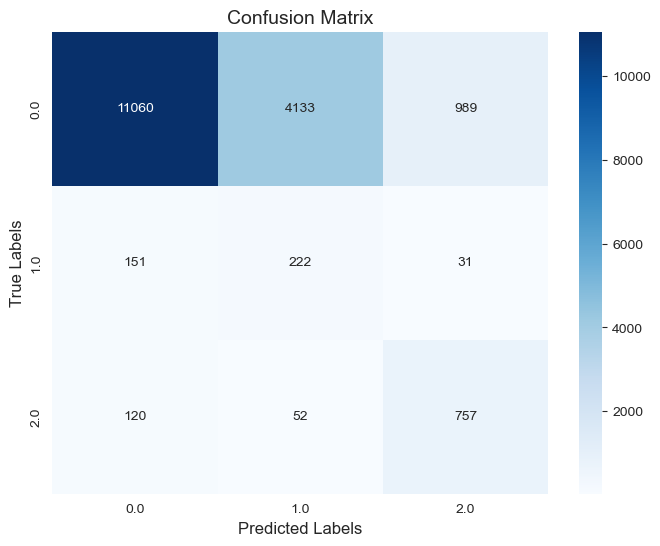

In [28]:
#  Matrice di confusione
plot_confusion_matrix(y_test, y_pred)

In [29]:
#Salvataggio dei risultati
columns_to_save = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf',  # Parametri del modello
    'mean_test_score', 'std_test_score', 'rank_test_score', 'precision', 'recall', 'f1_score', 'accuracy' #metrics
]

results = pd.DataFrame(grid_search.cv_results_)
results['precision'] = precision_score(y_test, y_pred, average='weighted')
results['recall'] = recall_score(y_test, y_pred, average='weighted')
results['f1_score'] = f1_score(y_test, y_pred, average='weighted')
results['accuracy'] = accuracy_score(y_test, y_pred)

save_grid_search_results(results, columns_to_save, 'rf_results.csv')

# Salvataggio del miglior modello RF
save_model(best_rf_model, "best_rf_model.pkl")

Risultati salvati con successo in: ./results/rf_results.csv
Modello salvato con successo in: ./models/best_rf_model.pkl


### XGBoost

In [30]:
# Creo del modello XGBoost
model = XGBClassifier(
    objective='multi:softmax',  # Per classificazione multiclasse
    random_state=42,
    eval_metric='mlogloss'      # Specifica la metrica di valutazione
)

# Definizione della griglia di iperparametri
param_grid = {
    'n_estimators': [100, 200],           # Numero di boosting rounds (limitato a 100 e 200)
    'learning_rate': [0.01, 0.1],         # Step size (limitato a 0.01 e 0.1)
    'max_depth': [3, 5],                   # Profondità massima dell'albero (limitato a 3 e 5)
    'subsample': [0.8, 1.0],               # Sottocampione dei dati (limitato a 0.8 e 1.0)
}

#  Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_weighted',  # Ottimizzare per F1-score ponderato
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Miglior modello
print("Migliori parametri trovati: ", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Migliori parametri trovati:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [31]:
#  Predizioni sul set di test
y_pred = best_xgb_model.predict(X_test)

# Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

Classification report on test set:
              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85     16182
         1.0       0.05      0.54      0.10       404
         2.0       0.73      0.87      0.79       929

    accuracy                           0.75     17515
   macro avg       0.59      0.72      0.58     17515
weighted avg       0.94      0.75      0.83     17515



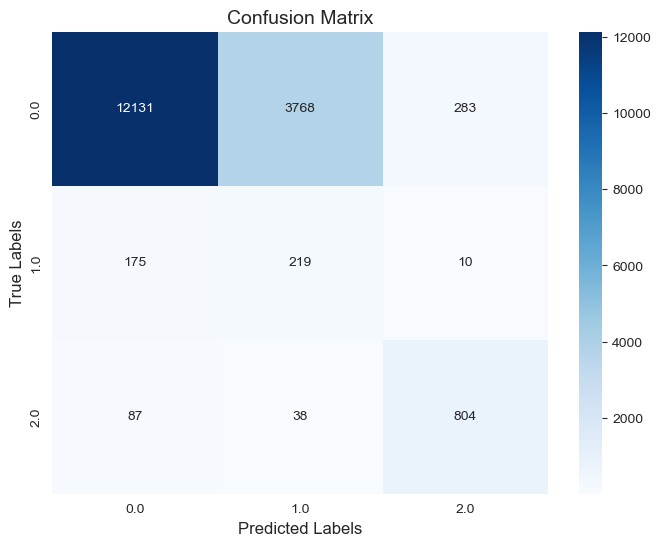

In [32]:
#plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [33]:
#Salvataggio dei risultati
columns_to_save = [
    'param_n_estimators', 'param_learning_rate', 'param_max_depth',
    'param_subsample',
    'mean_test_score', 'std_test_score', 'rank_test_score', 'precision', 'recall', 'f1_score', 'accuracy'
]

results = pd.DataFrame(grid_search.cv_results_)
results['precision'] = precision_score(y_test, y_pred, average='weighted')
results['recall'] = recall_score(y_test, y_pred, average='weighted')
results['f1_score'] = f1_score(y_test, y_pred, average='weighted')
results['accuracy'] = accuracy_score(y_test, y_pred)

save_grid_search_results(results, columns_to_save, 'xgb_results.csv')

# Salvataggio del miglior modello XGBoost
save_model(best_xgb_model, "best_xgb_model.pkl")

Risultati salvati con successo in: ./results/xgb_results.csv
Modello salvato con successo in: ./models/best_xgb_model.pkl


## SHAP

In [34]:
# Inizializza l'explainer SHAP per modelli basati su alberi
'''explainer = shap.TreeExplainer(best_rf_model)

# Calcola i valori SHAP per il dataset di test
shap_values = explainer.shap_values(X_test)

shap_values.shape'''

'explainer = shap.TreeExplainer(best_rf_model)\n\n# Calcola i valori SHAP per il dataset di test\nshap_values = explainer.shap_values(X_test)\n\nshap_values.shape'

In [35]:
X_test.shape

(17515, 28)

In [36]:
#len(shap_values)

In [37]:
best_rf_model = pickle.load(open('./models/best_rf_model.pkl', 'rb'))

In [38]:
X_test_pca_df = pd.DataFrame(X_test, columns=[f"PC_{i}" for i in range(X_test.shape[1])])

In [39]:
# compute SHAP values
#LOAD MODEL FROM PICKLE
explainer2 = shap.Explainer(best_rf_model, X_test_pca_df)
shap_values2 = explainer2(X_test_pca_df)

100%|===================| 52532/52545 [22:58<00:00]        

In [40]:
shap_values2.shape

(17515, 28, 3)

In [41]:
print(type(shap_values2))
print(len(shap_values2))  # Numero di classi
print(shap_values2[0].shape)  # Shape dei valori SHAP per la prima classe

<class 'shap._explanation.Explanation'>
17515
(28, 3)


In [42]:
class_names = ['alto','medio','basso']
for i, class_name in enumerate(class_names):
    shap.summary_plot(shap_values2[i], X_test_pca_df.values, plot_type='beeswarm',
                      class_names=class_names, feature_names=X_test_pca_df.columns.tolist())

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

TypeError: only integer scalar arrays can be converted to a scalar index

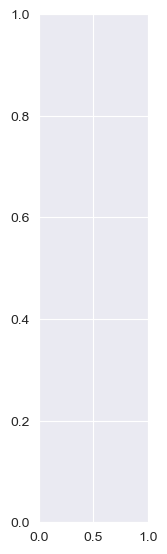

In [30]:
class_names = ['alto','medio','basso']
shap.summary_plot(shap_values2, X_test_pca_df.iloc[:17515], plot_type='beeswarm',
                  class_names=class_names, feature_names=X_test_pca_df.columns.tolist())

In [18]:
shap.plots.beeswarm(shap_values2, max_display=20)

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

ValueError: too many values to unpack (expected 2)

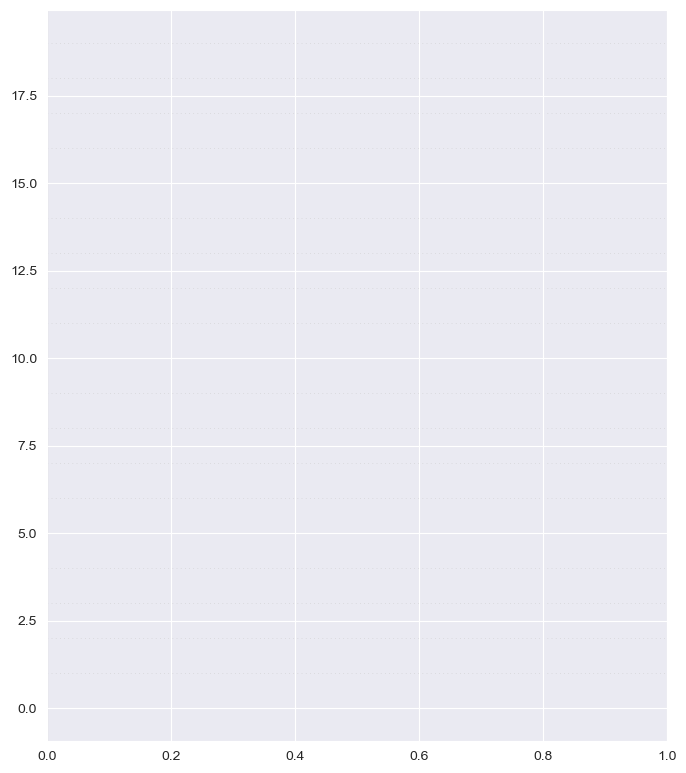

In [53]:
shap.plots.violin(shap_values2)

In [54]:
shap.plots.waterfall(shap_values2[0,0])

TypeError: only length-1 arrays can be converted to Python scalars

In [62]:
X_test_copy.shape

(17515, 52)

TypeError: only integer scalar arrays can be converted to a scalar index

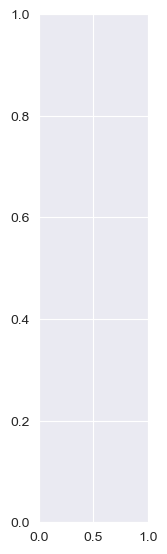

In [35]:
class_names = ['alto','medio','basso']


shap.summary_plot(shap_values2, X_test_pca_df.values, plot_type='beeswarm', class_names=class_names, feature_names=X_test_pca_df.columns.tolist())